In [ ]:
import psutil
import os

def print_memory_usage():
    """Print current memory usage statistics"""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    
    # System memory
    vm = psutil.virtual_memory()
    
    print(f"{'='*60}")
    print(f"MEMORY USAGE:")
    print(f"{'='*60}")
    print(f"Process Memory (this notebook):")
    print(f"  RSS (Resident Set Size): {mem_info.rss / 1024**3:.2f} GB")
    print(f"  VMS (Virtual Memory Size): {mem_info.vms / 1024**3:.2f} GB")
    print(f"\nSystem Memory:")
    print(f"  Total: {vm.total / 1024**3:.2f} GB")
    print(f"  Available: {vm.available / 1024**3:.2f} GB")
    print(f"  Used: {vm.used / 1024**3:.2f} GB ({vm.percent}%)")
    print(f"  Free: {vm.free / 1024**3:.2f} GB")
    print(f"{'='*60}\n")

# Check initial memory
print_memory_usage()


In [ ]:
import gc

def optimize_memory():
    """Force garbage collection and show memory freed"""
    print("Running garbage collection...")
    before = psutil.Process(os.getpid()).memory_info().rss / 1024**3
    
    collected = gc.collect()
    
    after = psutil.Process(os.getpid()).memory_info().rss / 1024**3
    freed = before - after
    
    print(f"  Collected {collected} objects")
    print(f"  Freed {freed:.3f} GB of memory")
    print(f"  Current memory usage: {after:.2f} GB\n")

def check_dataframe_memory(df, name="DataFrame"):
    """Check memory usage of a specific dataframe"""
    mem_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Memory: {mem_usage:.2f} MB")
    print(f"  Dtypes:\n{df.dtypes.value_counts()}\n")


## Memory Monitoring Guide

**In this notebook:**
- Call `print_memory_usage()` after each heavy operation to track memory
- Call `check_dataframe_memory(df, "name")` to see individual dataframe sizes
- Call `optimize_memory()` to force garbage collection and free memory

**In terminal (open separate SSH session with tmux):**
```bash
# Real-time memory monitoring (recommended - updates every 1 second)
watch -n 1 'free -h && echo "" && ps aux | grep python | grep -v grep | head -5'

# Or use htop for interactive detailed view
htop

# Quick memory check
free -h
```

**If kernel keeps crashing due to memory:**
1. Use `del variable_name` then `gc.collect()` to free large objects
2. Work with smaller subsets of data (filter by week, etc.)
3. Use dtype optimization: convert float64→float32, object→category
4. Restart kernel and run only essential cells


# Big Data Bowl: Getting Started

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import glob
from tqdm.auto import tqdm

# Set up paths - updated for Linux environment
data_dir = Path('/home/ubuntu/Big-Data-Bowl-26/data')
train_dir = data_dir / 'train'

print("Loading data...")
print(f"Data directory: {data_dir}")
print(f"Train directory: {train_dir}")


Loading data...
Data directory: /home/ubuntu/Big-Data-Bowl-26/data
Train directory: /home/ubuntu/Big-Data-Bowl-26/data/train


## Loading Data

In [2]:
# Load all input files (training data)
input_files = sorted(glob.glob(str(train_dir / 'input_2023_*.csv')))

# Load all input data into a single dataframe
input_dfs = []
for file in tqdm(input_files, desc="Loading input files", unit="file"):
    week = Path(file).stem.split('_')[-1]
    df = pd.read_csv(file)
    df['week'] = week  # Add week identifier
    input_dfs.append(df)

input_data = pd.concat(input_dfs, ignore_index=True)
print(f"✓ Loaded {len(input_files)} input files: {len(input_data):,} rows total")


Loading input files:   0%|          | 0/18 [00:00<?, ?file/s]

✓ Loaded 18 input files: 4,880,579 rows total


In [3]:
# Load all output files (target predictions)
output_files = sorted(glob.glob(str(train_dir / 'output_2023_*.csv')))

# Load all output data into a single dataframe
output_dfs = []
for file in tqdm(output_files, desc="Loading output files", unit="file"):
    week = Path(file).stem.split('_')[-1]
    df = pd.read_csv(file)
    df['week'] = week  # Add week identifier
    output_dfs.append(df)

output_data = pd.concat(output_dfs, ignore_index=True)
print(f"✓ Loaded {len(output_files)} output files: {len(output_data):,} rows total")

Loading output files:   0%|          | 0/18 [00:00<?, ?file/s]

✓ Loaded 18 output files: 562,936 rows total


In [4]:
print("Creating defender-offense relationships dataframe (VECTORIZED)...")
print("This analyzes the OUTPUT data (after ball is thrown)\n")

# Separate defense and offense in output data
offense_cols = ['game_id', 'play_id', 'frame_id', 'nfl_id', 'x', 'y', 'week']
defense_cols = ['game_id', 'play_id', 'frame_id', 'nfl_id', 'x', 'y', 'week']

# Get player info from input data (last frame contains all metadata)
player_info = input_data.groupby('nfl_id').agg({
    'player_name': 'first',
    'player_position': 'first',
    'player_role': 'first',
    'player_side': 'first',
    'o': 'first'  # We'll use orientation from input (last frame before throw)
}).reset_index()

# Get ball landing positions from input data
ball_info = input_data.groupby(['game_id', 'play_id']).agg({
    'ball_land_x': 'first',
    'ball_land_y': 'first'
}).reset_index()

# Merge output data with player info
output_with_info = output_data.merge(player_info, on='nfl_id', how='left')

# Separate into offense and defense
offense_output = output_with_info[output_with_info['player_side'] == 'Offense'].copy()
defense_output = output_with_info[output_with_info['player_side'] == 'Defense'].copy()

print(f"Offense frames: {len(offense_output):,}")
print(f"Defense frames: {len(defense_output):,}")

# Create cartesian product of defenders and offensive players per frame
print("\nCreating defender-offense pairs...")
defender_offense_pairs = defense_output.merge(
    offense_output,
    on=['game_id', 'play_id', 'frame_id', 'week'],
    suffixes=('_def', '_off')
)

print(f"Total pairs: {len(defender_offense_pairs):,}")

# Add ball information
print("Adding ball landing positions...")
defender_offense_pairs = defender_offense_pairs.merge(
    ball_info,
    on=['game_id', 'play_id'],
    how='left'
)

print("\nCalculating distances and orientations (vectorized)...")

# Calculate defender-to-offense distances and angles (vectorized)
dx_off = defender_offense_pairs['x_off'] - defender_offense_pairs['x_def']
dy_off = defender_offense_pairs['y_off'] - defender_offense_pairs['y_def']
defender_offense_pairs['distance_def_to_off'] = np.sqrt(dx_off**2 + dy_off**2)
defender_offense_pairs['angle_def_to_off'] = np.degrees(np.arctan2(dy_off, dx_off)) % 360

# Calculate orientation difference to offensive player
angle_diff = (defender_offense_pairs['angle_def_to_off'] - defender_offense_pairs['o_def'] + 180) % 360 - 180
defender_offense_pairs['orientation_diff_def_to_off'] = np.abs(angle_diff)

# Calculate defender-to-ball distances and angles (vectorized)
dx_ball = defender_offense_pairs['ball_land_x'] - defender_offense_pairs['x_def']
dy_ball = defender_offense_pairs['ball_land_y'] - defender_offense_pairs['y_def']
defender_offense_pairs['distance_def_to_ball'] = np.sqrt(dx_ball**2 + dy_ball**2)
defender_offense_pairs['angle_def_to_ball'] = np.degrees(np.arctan2(dy_ball, dx_ball)) % 360

# Calculate orientation difference to ball
angle_diff_ball = (defender_offense_pairs['angle_def_to_ball'] - defender_offense_pairs['o_def'] + 180) % 360 - 180
defender_offense_pairs['orientation_diff_def_to_ball'] = np.abs(angle_diff_ball)

# Clean up column names and select relevant columns
defender_offense_df = defender_offense_pairs[[
    'game_id', 'play_id', 'frame_id', 'week',
    'nfl_id_def', 'player_name_def', 'player_position_def', 'player_role_def',
    'x_def', 'y_def', 'o_def',
    'nfl_id_off', 'player_name_off', 'player_position_off', 'player_role_off',
    'x_off', 'y_off',
    'distance_def_to_off', 'angle_def_to_off', 'orientation_diff_def_to_off',
    'ball_land_x', 'ball_land_y',
    'distance_def_to_ball', 'angle_def_to_ball', 'orientation_diff_def_to_ball'
]].rename(columns={
    'nfl_id_def': 'defender_id',
    'player_name_def': 'defender_name',
    'player_position_def': 'defender_position',
    'player_role_def': 'defender_role',
    'x_def': 'defender_x',
    'y_def': 'defender_y',
    'o_def': 'defender_orientation',
    'nfl_id_off': 'offense_id',
    'player_name_off': 'offense_name',
    'player_position_off': 'offense_position',
    'player_role_off': 'offense_role',
    'x_off': 'offense_x',
    'y_off': 'offense_y'
})

print(f"\n✓ Created dataframe with {len(defender_offense_df):,} rows")
print(f"✓ Shape: {defender_offense_df.shape}")
print(f"✓ Memory usage: {defender_offense_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nSample of calculated metrics:")
display(defender_offense_df.head())


Creating defender-offense relationships dataframe (VECTORIZED)...
This analyzes the OUTPUT data (after ball is thrown)

Offense frames: 160,337
Defense frames: 402,599

Creating defender-offense pairs...
Total pairs: 402,553
Adding ball landing positions...

Calculating distances and orientations (vectorized)...

✓ Created dataframe with 402,553 rows
✓ Shape: (402553, 25)
✓ Memory usage: 213.49 MB

Sample of calculated metrics:


,game_id,play_id,frame_id,week,defender_id,defender_name,defender_position,defender_role,defender_x,defender_y,...,offense_x,offense_y,distance_def_to_off,angle_def_to_off,orientation_diff_def_to_off,ball_land_x,ball_land_y,distance_def_to_ball,angle_def_to_ball,orientation_diff_def_to_ball
0,2023090700,101,1,w01,46137,Justin Reid,SS,Defensive Coverage,56.22,17.28,...,53.20,13.98,4.473299,227.536762,40.143238,63.259998,-0.22,18.862968,291.914214,24.234214
1,2023090700,101,2,w01,46137,Justin Reid,SS,Defensive Coverage,56.63,16.88,...,53.96,13.78,4.091320,229.261998,38.418002,63.259998,-0.22,18.340307,291.192268,23.512268
2,2023090700,101,3,w01,46137,Justin Reid,SS,Defensive Coverage,57.06,16.46,...,54.70,13.54,3.754464,231.054192,36.625808,63.259998,-0.22,17.795010,290.390228,22.710228
3,2023090700,101,4,w01,46137,Justin Reid,SS,Defensive Coverage,57.48,16.02,...,55.41,13.27,3.442005,233.030226,34.649774,63.259998,-0.22,17.237923,289.591215,21.911215
4,2023090700,101,5,w01,46137,Justin Reid,SS,Defensive Coverage,57.91,15.56,...,56.09,12.95,3.181902,235.111242,32.568758,63.259998,-0.22,16.662259,288.728542,21.048542


In [ ]:
# Check memory usage of main dataframes
print("\n" + "="*60)
print("CHECKING MEMORY USAGE OF MAIN DATAFRAMES")
print("="*60 + "\n")

check_dataframe_memory(input_data, "input_data (raw INPUT tracking)")
check_dataframe_memory(output_data, "output_data (raw OUTPUT tracking)")
check_dataframe_memory(defender_offense_df, "defender_offense_df (OUTPUT with calculations)")
check_dataframe_memory(input_defender_offense_df, "input_defender_offense_df (INPUT with calculations)")

if 'supplementary_data' in globals():
    check_dataframe_memory(supplementary_data, "supplementary_data")

print("\nOverall memory status:")
print_memory_usage()

print("\n⚠️  If memory is high (>80%), consider:")
print("   1. Running optimize_memory() to free up space")
print("   2. Deleting dataframes you don't need anymore")
print("   3. Restarting the kernel to clear everything")


In [5]:
print("Creating defender-offense relationships dataframe for INPUT data (before ball is thrown)...\n")

# Get player info from input data
player_info_input = input_data.groupby('nfl_id').agg({
    'player_name': 'first',
    'player_position': 'first',
    'player_role': 'first',
    'player_side': 'first'
}).reset_index()

# Get ball landing positions from input data
ball_info_input = input_data.groupby(['game_id', 'play_id']).agg({
    'ball_land_x': 'first',
    'ball_land_y': 'first'
}).reset_index()

# Merge input data with player info
input_with_info = input_data.merge(player_info_input, on='nfl_id', how='left', suffixes=('', '_info'))

# Use the original columns, not the _info ones
input_with_info['player_name'] = input_with_info['player_name'].fillna(input_with_info['player_name_info'])
input_with_info['player_position'] = input_with_info['player_position'].fillna(input_with_info['player_position_info'])
input_with_info['player_role'] = input_with_info['player_role'].fillna(input_with_info['player_role_info'])
input_with_info['player_side'] = input_with_info['player_side'].fillna(input_with_info['player_side_info'])

# Separate into offense and defense
offense_input = input_with_info[input_with_info['player_side'] == 'Offense'].copy()
defense_input = input_with_info[input_with_info['player_side'] == 'Defense'].copy()

print(f"Offense frames: {len(offense_input):,}")
print(f"Defense frames: {len(defense_input):,}")

# Create cartesian product of defenders and offensive players per frame
print("\nCreating defender-offense pairs...")
input_defender_offense_pairs = defense_input.merge(
    offense_input,
    on=['game_id', 'play_id', 'frame_id', 'week'],
    suffixes=('_def', '_off')
)

print(f"Total pairs: {len(input_defender_offense_pairs):,}")

# Add ball information
print("Adding ball landing positions...")
input_defender_offense_pairs = input_defender_offense_pairs.merge(
    ball_info_input,
    on=['game_id', 'play_id'],
    how='left'
)

print("\nCalculating distances and orientations (vectorized)...")

# Calculate defender-to-offense distances and angles (vectorized)
dx_off = input_defender_offense_pairs['x_off'] - input_defender_offense_pairs['x_def']
dy_off = input_defender_offense_pairs['y_off'] - input_defender_offense_pairs['y_def']
input_defender_offense_pairs['distance_def_to_off'] = np.sqrt(dx_off**2 + dy_off**2)
input_defender_offense_pairs['angle_def_to_off'] = np.degrees(np.arctan2(dy_off, dx_off)) % 360

# Calculate orientation difference to offensive player
angle_diff = (input_defender_offense_pairs['angle_def_to_off'] - input_defender_offense_pairs['o_def'] + 180) % 360 - 180
input_defender_offense_pairs['orientation_diff_def_to_off'] = np.abs(angle_diff)

# Calculate defender-to-ball distances and angles (vectorized)
dx_ball = input_defender_offense_pairs['ball_land_x'] - input_defender_offense_pairs['x_def']
dy_ball = input_defender_offense_pairs['ball_land_y'] - input_defender_offense_pairs['y_def']
input_defender_offense_pairs['distance_def_to_ball'] = np.sqrt(dx_ball**2 + dy_ball**2)
input_defender_offense_pairs['angle_def_to_ball'] = np.degrees(np.arctan2(dy_ball, dx_ball)) % 360

# Calculate orientation difference to ball
angle_diff_ball = (input_defender_offense_pairs['angle_def_to_ball'] - input_defender_offense_pairs['o_def'] + 180) % 360 - 180
input_defender_offense_pairs['orientation_diff_def_to_ball'] = np.abs(angle_diff_ball)

# Clean up column names and select relevant columns
input_defender_offense_df = input_defender_offense_pairs[[
    'game_id', 'play_id', 'frame_id', 'week',
    'nfl_id_def', 'player_name_def', 'player_position_def', 'player_role_def',
    'x_def', 'y_def', 'o_def',
    'nfl_id_off', 'player_name_off', 'player_position_off', 'player_role_off',
    'x_off', 'y_off',
    'distance_def_to_off', 'angle_def_to_off', 'orientation_diff_def_to_off',
    'ball_land_x', 'ball_land_y',
    'distance_def_to_ball', 'angle_def_to_ball', 'orientation_diff_def_to_ball'
]].rename(columns={
    'nfl_id_def': 'defender_id',
    'player_name_def': 'defender_name',
    'player_position_def': 'defender_position',
    'player_role_def': 'defender_role',
    'x_def': 'defender_x',
    'y_def': 'defender_y',
    'o_def': 'defender_orientation',
    'nfl_id_off': 'offense_id',
    'player_name_off': 'offense_name',
    'player_position_off': 'offense_position',
    'player_role_off': 'offense_role',
    'x_off': 'offense_x',
    'y_off': 'offense_y'
})

print(f"\n✓ Created INPUT defender-offense dataframe with {len(input_defender_offense_df):,} rows")
print(f"✓ Shape: {input_defender_offense_df.shape}")
print(f"✓ Memory usage: {input_defender_offense_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nSample of calculated metrics:")
display(input_defender_offense_df.head())


Creating defender-offense relationships dataframe for INPUT data (before ball is thrown)...

Offense frames: 2,217,922
Defense frames: 2,662,657

Creating defender-offense pairs...


: 

## Key Metrics Explained

The `defender_offense_df` dataframe contains the following key metrics for **OUTPUT data (after ball is thrown)**:

**Distance Metrics:**
- `distance_def_to_off`: Euclidean distance (yards) between defender and offensive player
- `distance_def_to_ball`: Euclidean distance (yards) between defender and ball landing location

**Orientation Metrics:**
- `angle_def_to_off`: Angle (0-360°) from defender to offensive player
- `angle_def_to_ball`: Angle (0-360°) from defender to ball landing location
- `orientation_diff_def_to_off`: How well defender is facing the offensive player (0° = directly facing, 180° = facing away)
- `orientation_diff_def_to_ball`: How well defender is facing the ball (0° = directly facing, 180° = facing away)

**Context:**
- Each row represents one defender-offense pairing in a specific frame **after the ball is thrown**
- All pairwise combinations are included (e.g., if 11 defenders and 11 offensive players, each frame will have 121 rows)
- Use `player_role` to filter for specific roles like 'Targeted Receiver' or 'Defensive Coverage'
- Orientation values are taken from the input data (last frame before ball was thrown)


In [6]:
# Load supplementary data (play-level metadata)
supplementary_data = pd.read_csv(data_dir / 'supplementary_data.csv')
print(f"Supplementary data: {len(supplementary_data):,} rows")
print(f"Columns: {list(supplementary_data.columns)}")


Supplementary data: 18,009 rows
Columns: ['game_id', 'season', 'week', 'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr', 'play_id', 'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go', 'possession_team', 'defensive_team', 'yardline_side', 'yardline_number', 'pre_snap_home_score', 'pre_snap_visitor_score', 'play_nullified_by_penalty', 'pass_result', 'pass_length', 'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver', 'play_action', 'dropback_type', 'dropback_distance', 'pass_location_type', 'defenders_in_the_box', 'team_coverage_man_zone', 'team_coverage_type', 'penalty_yards', 'pre_penalty_yards_gained', 'yards_gained', 'expected_points', 'expected_points_added', 'pre_snap_home_team_win_probability', 'pre_snap_visitor_team_win_probability', 'home_team_win_probability_added', 'visitor_team_win_probility_added']


/tmp/ipykernel_23566/2333597478.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_data = pd.read_csv(data_dir / 'supplementary_data.csv')


## EDA

In [ ]:
print("Applying filters to identify qualifying plays...\n")
print("Filter 1: Defender's back is facing the ball at throw (orientation > 90°)")
print("Filter 2: Ball traveled further than defender's distance to QB at throw")
print("Filter 3: Conditions must be met for NEAREST defender to targeted receiver at throw\n")

# Get QB (passer) position at throw time (last frame of input)
input_last_frames = input_data.groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
input_last_frames.columns = ['game_id', 'play_id', 'last_input_frame']

input_last_data = input_data.merge(input_last_frames, on=['game_id', 'play_id'])
input_last_data = input_last_data[input_last_data['frame_id'] == input_last_data['last_input_frame']]

# Get passer position (ball starting position)
passer_position = input_last_data[input_last_data['player_role'] == 'Passer'][
    ['game_id', 'play_id', 'x', 'y']
].rename(columns={'x': 'ball_start_x', 'y': 'ball_start_y'})

# Get defender positions and orientations at throw time
defenders_at_throw = input_last_data[input_last_data['player_side'] == 'Defense'][
    ['game_id', 'play_id', 'nfl_id', 'player_name', 'player_role', 'x', 'y', 'o']
].rename(columns={'x': 'def_x_at_throw', 'y': 'def_y_at_throw', 'o': 'def_o_at_throw'})

# Merge with passer position
defenders_at_throw = defenders_at_throw.merge(passer_position, on=['game_id', 'play_id'])

# Calculate defender orientation to ball start (QB position)
dx_to_qb = defenders_at_throw['ball_start_x'] - defenders_at_throw['def_x_at_throw']
dy_to_qb = defenders_at_throw['ball_start_y'] - defenders_at_throw['def_y_at_throw']

angle_to_qb = np.degrees(np.arctan2(dy_to_qb, dx_to_qb)) % 360
defenders_at_throw['orientation_diff_to_ball_start'] = np.abs(
    (angle_to_qb - defenders_at_throw['def_o_at_throw'] + 180) % 360 - 180
)

# Calculate distance from defender to ball start (QB)
defenders_at_throw['distance_to_ball_start'] = np.sqrt(dx_to_qb**2 + dy_to_qb**2)

# Get ball landing positions
ball_landing = input_data.groupby(['game_id', 'play_id']).agg({
    'ball_land_x': 'first',
    'ball_land_y': 'first'
}).reset_index()

defenders_at_throw = defenders_at_throw.merge(ball_landing, on=['game_id', 'play_id'])

# Calculate ball travel distance
defenders_at_throw['ball_travel_distance'] = np.sqrt(
    (defenders_at_throw['ball_land_x'] - defenders_at_throw['ball_start_x'])**2 +
    (defenders_at_throw['ball_land_y'] - defenders_at_throw['ball_start_y'])**2
)

# Apply filters
defenders_at_throw['back_to_ball'] = defenders_at_throw['orientation_diff_to_ball_start'] > 90
defenders_at_throw['ball_traveled_further'] = (
    defenders_at_throw['ball_travel_distance'] > defenders_at_throw['distance_to_ball_start']
)
defenders_at_throw['meets_conditions'] = (
    defenders_at_throw['back_to_ball'] & defenders_at_throw['ball_traveled_further']
)

# Find closest defender to targeted receiver at throw time
offense_at_throw = input_last_data[input_last_data['player_side'] == 'Offense'][
    ['game_id', 'play_id', 'nfl_id', 'x', 'y', 'player_role']
]
defense_at_throw = input_last_data[input_last_data['player_side'] == 'Defense'][
    ['game_id', 'play_id', 'nfl_id', 'x', 'y']
]

# Create defender-receiver pairs
throw_pairs = defense_at_throw.merge(
    offense_at_throw, 
    on=['game_id', 'play_id'], 
    suffixes=('_def', '_off')
)

# Filter for targeted receivers only
throw_pairs = throw_pairs[throw_pairs['player_role'] == 'Targeted Receiver']

# Calculate distances
throw_pairs['distance'] = np.sqrt(
    (throw_pairs['x_def'] - throw_pairs['x_off'])**2 + 
    (throw_pairs['y_def'] - throw_pairs['y_off'])**2
)

# Find closest defender to each targeted receiver
closest_defenders = throw_pairs.loc[
    throw_pairs.groupby(['game_id', 'play_id', 'nfl_id_off'])['distance'].idxmin()
][['game_id', 'play_id', 'nfl_id_def', 'nfl_id_off']].rename(columns={
    'nfl_id_def': 'closest_defender_id',
    'nfl_id_off': 'targeted_receiver_id'
})

print(f"Found {len(closest_defenders)} plays with targeted receivers")

# Check if the closest defender meets conditions
closest_defenders_with_conditions = closest_defenders.merge(
    defenders_at_throw[['game_id', 'play_id', 'nfl_id', 'meets_conditions', 
                        'back_to_ball', 'ball_traveled_further']],
    left_on=['game_id', 'play_id', 'closest_defender_id'],
    right_on=['game_id', 'play_id', 'nfl_id']
)

# Filter to only plays where closest defender meets conditions
qualifying_plays = closest_defenders_with_conditions[
    closest_defenders_with_conditions['meets_conditions']
][['game_id', 'play_id', 'closest_defender_id']].rename(columns={
    'closest_defender_id': 'qualifying_defender_id'
})

print(f"\nPlays where CLOSEST defender meets both conditions: {len(qualifying_plays)}")
print(f"Percentage: {100 * len(qualifying_plays) / len(closest_defenders):.1f}%")

# Filter defender_offense_df to only these plays
filtered_defender_offense_df = defender_offense_df.merge(
    qualifying_plays[['game_id', 'play_id']],
    on=['game_id', 'play_id'],
    how='inner'
)

print(f"\nFiltered defender_offense_df: {len(filtered_defender_offense_df):,} rows (from {len(defender_offense_df):,})")
print(f"Percentage retained: {100 * len(filtered_defender_offense_df) / len(defender_offense_df):.1f}%")

Applying filters to identify qualifying plays...

Filter 1: Defender's back is facing the ball at throw (orientation > 90°)
Filter 2: Ball traveled further than defender's distance to QB at throw
Filter 3: Conditions must be met for NEAREST defender to targeted receiver at throw

Found 14107 plays with targeted receivers

Plays where CLOSEST defender meets both conditions: 3879
Percentage: 27.5%

Filtered defender_offense_df: 148,758 rows (from 402,553)
Percentage retained: 37.0%


Analyzing completion percentage by defender metrics at ball arrival...

Found ball arrival frames for 435 receiver instances
Defender-receiver pairs at ball arrival: 1,137
Unique plays with closest defender at arrival: 435
Calculated defender orientation to ball position 10 frames before arrival
Plays with pass result data: 435
Overall completion rate: 76.1%

Using distance from defender to ball landing position at arrival


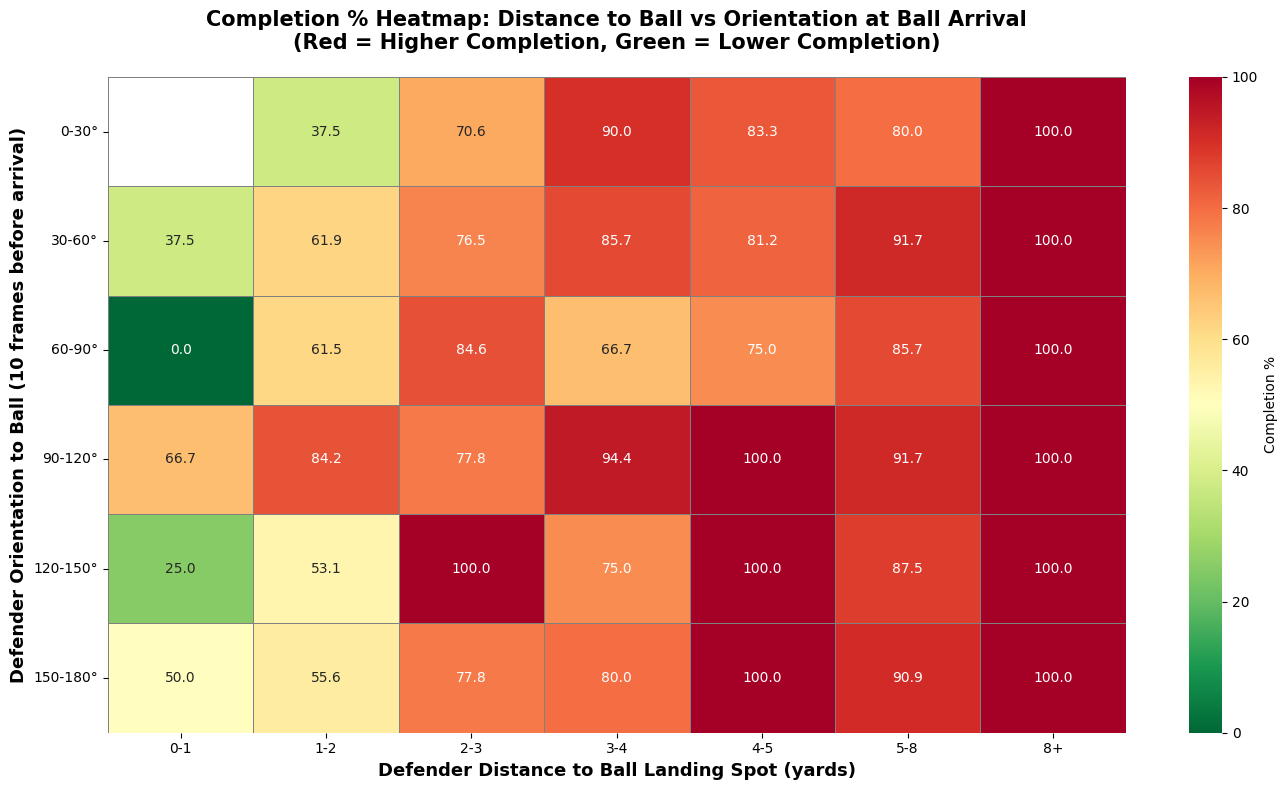

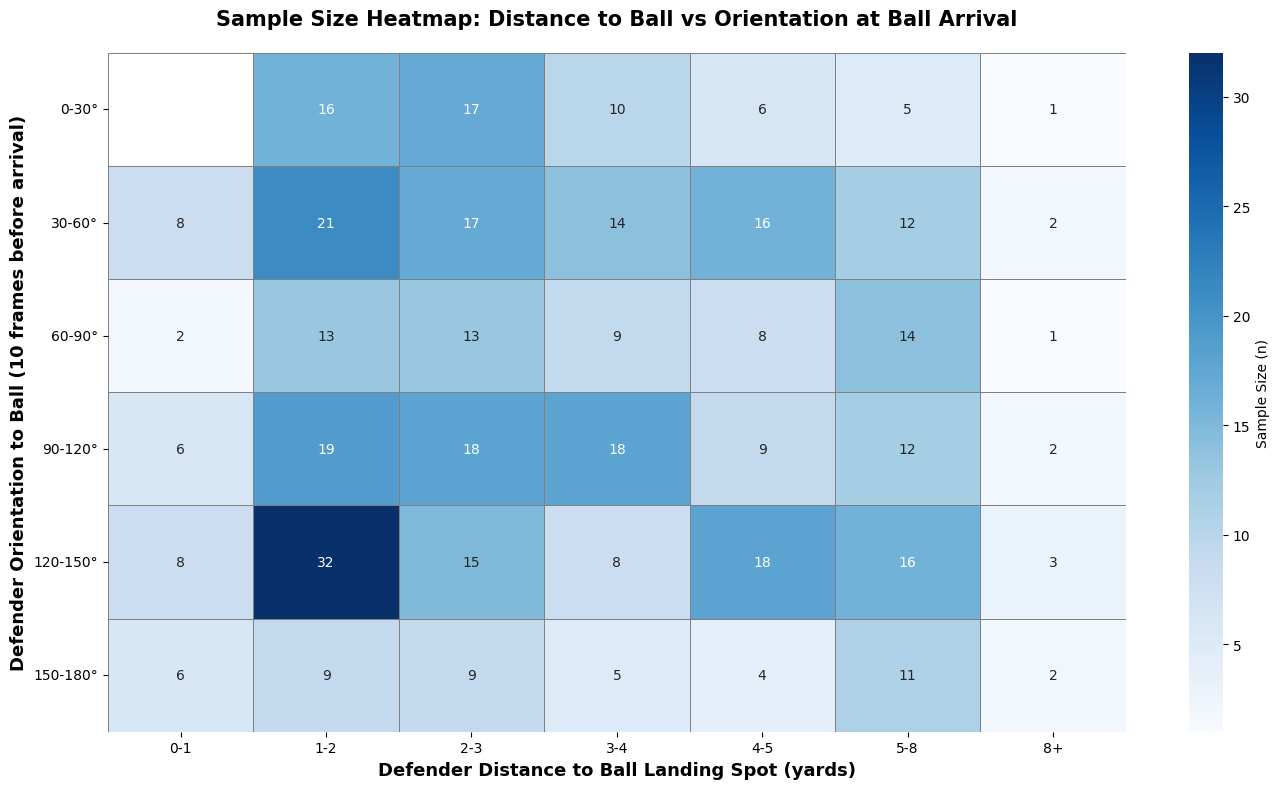

In [8]:
import matplotlib.pyplot as plt

print("Analyzing completion percentage by defender metrics at ball arrival...\n")

# Step 1: Find the frame where ball is within 1 yard of receiver
# For each play, get the targeted receiver's position over time
targeted_receiver_frames = filtered_defender_offense_df[
    filtered_defender_offense_df['offense_role'] == 'Targeted Receiver'
].copy()

# Calculate distance from receiver to ball landing spot for each frame
targeted_receiver_frames['distance_to_ball_land'] = np.sqrt(
    (targeted_receiver_frames['offense_x'] - targeted_receiver_frames['ball_land_x'])**2 +
    (targeted_receiver_frames['offense_y'] - targeted_receiver_frames['ball_land_y'])**2
)

# Find the first frame where receiver is within 1 yard of ball landing spot
ball_arrival_frames = targeted_receiver_frames[
    targeted_receiver_frames['distance_to_ball_land'] <= 1.0
].groupby(['game_id', 'play_id', 'offense_id']).agg({
    'frame_id': 'min'  # Get the first frame where within 1 yard
}).reset_index().rename(columns={'frame_id': 'ball_arrival_frame'})

print(f"Found ball arrival frames for {len(ball_arrival_frames)} receiver instances")

# Step 2: Get defender metrics at ball arrival frame
# Merge to get only the data at ball arrival frame
ball_arrival_data = filtered_defender_offense_df.merge(
    ball_arrival_frames,
    on=['game_id', 'play_id', 'offense_id']
)

ball_arrival_data = ball_arrival_data[
    (ball_arrival_data['frame_id'] == ball_arrival_data['ball_arrival_frame']) &
    (ball_arrival_data['offense_role'] == 'Targeted Receiver')
]

print(f"Defender-receiver pairs at ball arrival: {len(ball_arrival_data):,}")

# For each play, find the closest defender to the targeted receiver at ball arrival
closest_at_arrival = ball_arrival_data.loc[
    ball_arrival_data.groupby(['game_id', 'play_id', 'offense_id'])['distance_def_to_off'].idxmin()
]

print(f"Unique plays with closest defender at arrival: {len(closest_at_arrival)}")

# Step 3: Calculate where ball was 10 frames before arrival
# Get QB position (ball start) for each play
qb_positions = input_last_data[input_last_data['player_role'] == 'Passer'][
    ['game_id', 'play_id', 'x', 'y']
].rename(columns={'x': 'qb_x', 'y': 'qb_y'})

closest_at_arrival = closest_at_arrival.merge(qb_positions, on=['game_id', 'play_id'], how='left')

# Calculate ball position 10 frames before arrival
# Assuming roughly linear trajectory from QB to landing spot
# Ball position at frame N = QB_pos + (landing_pos - QB_pos) * (N / total_frames)
frames_before_arrival = 10
ball_frame_calc = closest_at_arrival['ball_arrival_frame'] - frames_before_arrival

# Calculate what fraction of the flight the ball had completed 10 frames before arrival
flight_fraction = ball_frame_calc / closest_at_arrival['ball_arrival_frame']
flight_fraction = flight_fraction.clip(lower=0)  # Don't go negative

# Ball position 10 frames before arrival
ball_x_before = closest_at_arrival['qb_x'] + (
    closest_at_arrival['ball_land_x'] - closest_at_arrival['qb_x']
) * flight_fraction

ball_y_before = closest_at_arrival['qb_y'] + (
    closest_at_arrival['ball_land_y'] - closest_at_arrival['qb_y']
) * flight_fraction

# Calculate defender's orientation to ball's position 10 frames before arrival
dx_to_ball_before = ball_x_before - closest_at_arrival['defender_x']
dy_to_ball_before = ball_y_before - closest_at_arrival['defender_y']

angle_to_ball_before = np.degrees(np.arctan2(dy_to_ball_before, dx_to_ball_before)) % 360

# Calculate orientation difference
closest_at_arrival['orientation_diff_to_ball_before'] = np.abs(
    (angle_to_ball_before - closest_at_arrival['defender_orientation'] + 180) % 360 - 180
)

print(f"Calculated defender orientation to ball position 10 frames before arrival")

# Step 4: Get pass completion results from supplementary data
pass_results = supplementary_data[['game_id', 'play_id', 'pass_result']].copy()
pass_results['completion'] = (pass_results['pass_result'] == 'C').astype(int)

closest_at_arrival = closest_at_arrival.merge(
    pass_results,
    on=['game_id', 'play_id'],
    how='left'
)

# Remove plays without pass result data
closest_at_arrival = closest_at_arrival.dropna(subset=['pass_result'])

print(f"Plays with pass result data: {len(closest_at_arrival)}")
print(f"Overall completion rate: {100 * closest_at_arrival['completion'].mean():.1f}%\n")

# Step 5: Create buckets and calculate completion percentage
# Calculate distance from defender to ball landing position (instead of to receiver)
closest_at_arrival['distance_def_to_ball_land'] = np.sqrt(
    (closest_at_arrival['defender_x'] - closest_at_arrival['ball_land_x'])**2 +
    (closest_at_arrival['defender_y'] - closest_at_arrival['ball_land_y'])**2
)

print(f"Using distance from defender to ball landing position at arrival")

# Distance buckets (0-1 yard, 1-2 yards, 2-3 yards, etc.)
distance_bins = [0, 1, 2, 3, 4, 5, 8, 15]
distance_labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-8', '8+']
closest_at_arrival['distance_bucket'] = pd.cut(
    closest_at_arrival['distance_def_to_ball_land'],
    bins=distance_bins,
    labels=distance_labels,
    include_lowest=True
)

# Orientation difference buckets (using the new calculation to ball 10 frames before)
orientation_bins = [0, 30, 60, 90, 120, 150, 180]
orientation_labels = ['0-30°', '30-60°', '60-90°', '90-120°', '120-150°', '150-180°']
closest_at_arrival['orientation_bucket'] = pd.cut(
    closest_at_arrival['orientation_diff_to_ball_before'],
    bins=orientation_bins,
    labels=orientation_labels,
    include_lowest=True
)

# Calculate completion percentage by bucket
distance_stats = closest_at_arrival.groupby('distance_bucket', observed=True).agg({
    'completion': ['mean', 'count']
}).reset_index()
distance_stats.columns = ['distance_bucket', 'completion_pct', 'count']
distance_stats['completion_pct'] *= 100

orientation_stats = closest_at_arrival.groupby('orientation_bucket', observed=True).agg({
    'completion': ['mean', 'count']
}).reset_index()
orientation_stats.columns = ['orientation_bucket', 'completion_pct', 'count']
orientation_stats['completion_pct'] *= 100

# Step 5: Create 2D heatmap across both dimensions
# Create pivot table for heatmap
heatmap_data = closest_at_arrival.groupby(['distance_bucket', 'orientation_bucket'], observed=True).agg({
    'completion': ['mean', 'count']
}).reset_index()
heatmap_data.columns = ['distance_bucket', 'orientation_bucket', 'completion_pct', 'count']
heatmap_data['completion_pct'] *= 100

# Pivot for heatmap
completion_pivot = heatmap_data.pivot(
    index='orientation_bucket', 
    columns='distance_bucket', 
    values='completion_pct'
)

count_pivot = heatmap_data.pivot(
    index='orientation_bucket', 
    columns='distance_bucket', 
    values='count'
)

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap
import seaborn as sns
sns.heatmap(completion_pivot, 
            annot=True, 
            fmt='.1f',
            cmap='RdYlGn_r',  # Red = high completion (bad for defense), Green = low completion (good for defense)
            center=50,
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Completion %'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_xlabel('Defender Distance to Ball Landing Spot (yards)', fontsize=13, fontweight='bold')
ax.set_ylabel('Defender Orientation to Ball (10 frames before arrival)', fontsize=13, fontweight='bold')
ax.set_title('Completion % Heatmap: Distance to Ball vs Orientation at Ball Arrival\n(Red = Higher Completion, Green = Lower Completion)', 
             fontsize=15, fontweight='bold', pad=20)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Create a second heatmap showing sample sizes
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(count_pivot, 
            annot=True, 
            fmt='.0f',
            cmap='Blues',
            cbar_kws={'label': 'Sample Size (n)'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_xlabel('Defender Distance to Ball Landing Spot (yards)', fontsize=13, fontweight='bold')
ax.set_ylabel('Defender Orientation to Ball (10 frames before arrival)', fontsize=13, fontweight='bold')
ax.set_title('Sample Size Heatmap: Distance to Ball vs Orientation at Ball Arrival', 
             fontsize=15, fontweight='bold', pad=20)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [9]:
print("Analyzing top defenders: % of reps with tight coverage (0-2 yards) and good ball tracking (<90°)\n")

# Define the criteria for "elite coverage moment"
closest_at_arrival['elite_coverage'] = (
    (closest_at_arrival['distance_def_to_ball_land'] <= 2.0) &
    (closest_at_arrival['orientation_diff_to_ball_before'] < 90)
)

# Count total plays and elite coverage plays per defender
defender_stats = closest_at_arrival.groupby('defender_name').agg({
    'play_id': 'count',
    'elite_coverage': 'sum'
}).rename(columns={
    'play_id': 'total_plays',
    'elite_coverage': 'elite_coverage_plays'
})

# Calculate percentage
defender_stats['elite_coverage_pct'] = (
    100 * defender_stats['elite_coverage_plays'] / defender_stats['total_plays']
).round(1)

# Filter to defenders with at least 10 plays
defender_stats = defender_stats[defender_stats['total_plays'] >= 1]

# Sort by total plays to get "top" players
defender_stats = defender_stats.sort_values('total_plays', ascending=False)

print(f"Defenders with at least 10 plays: {len(defender_stats)}")
print(f"\nOverall: {closest_at_arrival['elite_coverage'].sum()} elite coverage moments out of {len(closest_at_arrival)} plays")
print(f"Overall elite coverage rate: {100 * closest_at_arrival['elite_coverage'].mean():.1f}%\n")

print("="*80)
print("Top 20 Defenders by Total Plays (with Elite Coverage %)")
print("="*80)
display(defender_stats.head(20))

print("\n" + "="*80)
print("Top 20 Defenders by Elite Coverage % (minimum 10 plays)")
print("="*80)
defender_stats_by_pct = defender_stats.sort_values('elite_coverage_pct', ascending=False)
display(defender_stats_by_pct.head())


Analyzing top defenders: % of reps with tight coverage (0-2 yards) and good ball tracking (<90°)

Defenders with at least 10 plays: 245

Overall: 60 elite coverage moments out of 435 plays
Overall elite coverage rate: 13.8%

Top 20 Defenders by Total Plays (with Elite Coverage %)


,total_plays,elite_coverage_plays,elite_coverage_pct
defender_name,,,
Michael Davis,8,2,25.0
Deonte Banks,7,1,14.3
Cameron Sutton,7,1,14.3
Darius Slay,6,1,16.7
Charvarius Ward,6,2,33.3
David Long Jr.,5,0,0.0
Riq Woolen,5,2,40.0
Marcus Peters,5,0,0.0
Adoree' Jackson,5,2,40.0



Top 20 Defenders by Elite Coverage % (minimum 10 plays)


,total_plays,elite_coverage_plays,elite_coverage_pct
defender_name,,,
Akayleb Evans,1,1,100.0
Kindle Vildor,1,1,100.0
Deane Leonard,1,1,100.0
Isaiah Pola-Mao,1,1,100.0
Jason Pinnock,1,1,100.0


This is a legit terrible list of players. Onto the next idea lol

### Identifying the "Robber"